## Trabalho Prático Aprendizagem Automática

In [1]:
import pickle

import numpy as np
import matplotlib.pyplot as plt
import mglearn

import re

import nltk
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_curve, classification_report


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anaso\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\anaso\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Pré-Processamento

In [2]:
def limpeza(critica): 
    critica = critica.replace("<br />", " ")
    critica = re.sub(r'[^a-zA-Z]+', ' ', critica.lower())
    return critica

def stopWords(critica): 
    stop_words = set(stopwords.words('english'))
    no_stop_words = " ".join((palavra if palavra not in stop_words else " ") for palavra in critica.split()) 
    return no_stop_words

def lematizacao(critica, lemma=WordNetLemmatizer()): 
    lemma = " ".join((lemma.lemmatize(palavra)) for palavra in critica.split())
    return lemma


In [3]:
def text2vector(corpus, tfidf=TfidfVectorizer(min_df=3, max_df=0.75, ngram_range=(1,3), token_pattern=r'\b\w{3,}\b'), treino=True):

    docs = [limpeza(texto) for texto in corpus]
    docs = [stopWords(texto) for texto in docs] 
    docs = [lematizacao(texto) for texto in docs]
    
    if(treino):
        modelo = tfidf.fit(docs)
        Dict = {'tfidf_model': modelo}
        pickle.dump(Dict, open('models/tfidf.p', 'wb'))
        
    else:
        Dict = pickle.load(open('models/tfidf.p', 'rb'))
        tfidf = Dict['tfidf_model']

    return tfidf.transform(docs)


## Classificação Binária

In [4]:
def binClassify(X, y, model='LogisticRegression', treino=False):

    if(len(np.unique(y))>2):
        raise ValueError("Targets errados. ")
    
    else:
        modelos = {
            "LogisticRegression": LogisticRegression(max_iter=10000, C=10, penalty='l2', solver='liblinear', tol=1e-3), 
            "LinearSVC": LinearSVC(C=1, loss='hinge', max_iter=10000, tol=1e-4), 
            "SVC": SVC(C=0.1, degree=1, gamma=10, kernel='poly', max_iter=10000), 
            "NaiveBayes": MultinomialNB()
        }    

        modelo = modelos.get(model)

        if(treino): 
            modelo = modelo.fit(X, y)
            Dict = {model: modelo}
            pickle.dump(Dict, open('models/b_'+model+'.p', 'wb'))

        elif(not treino):
            Dict = pickle.load(open('models/b_'+model+'.p', 'rb'))
            modelo = Dict[model]
        
        try:
            fpr, tpr, _ = roc_curve(y, modelo.decision_function(X))
        except: 
            fpr, tpr, _ = roc_curve(y, modelo.predict_proba(X)[:, 1])
            
        print("Score: ", np.round(modelo.score(X, y), 3))
        return modelo.predict(X), fpr, tpr

## Classificação Multiclasse

In [5]:
def multiClassify(X, y, model='LogisticRegression', treino=False):

    if(len(np.unique(y))<=2):
        raise ValueError("Targets errados. ")
    
    else:
        modelos = {            
            "LogisticRegression": LogisticRegression(C=100, max_iter=10000, multi_class='ovr', solver='saga', tol=0.001),            
            "LinearSVC": LinearSVC(C=0.01, loss='hinge', max_iter=10000, tol=0.001), 
            "SVC": SVC(C=10, degree=1, gamma=10, kernel='poly', max_iter=5000),
            "NaiveBayes": MultinomialNB(alpha=0.1)
        }    

        modelo = modelos.get(model)
        
        if(treino): 
            modelo = modelo.fit(X, y)
            Dict = {model: modelo}
            pickle.dump(Dict, open('models/m_'+model+'.p', 'wb'))

        elif(not treino):
            Dict = pickle.load(open('models/m_'+model+'.p', 'rb'))
            modelo = Dict[model]
        
        print("Score: ", np.round(modelo.score(X, y), 3))
        return modelo.predict(X)

## Testes

In [6]:
fN = '/Users/anaso/Documents/AA/AA-22-23/Trabalho Final/imdbFull.p'

D = pickle.load(open(fN, 'rb'))

nDocs = 5000

corpus = D.data#[:nDocs]
y = D.target#[:nDocs]
yb = [1 if val > 5 else 0 for val in y]


### Classificação Binária

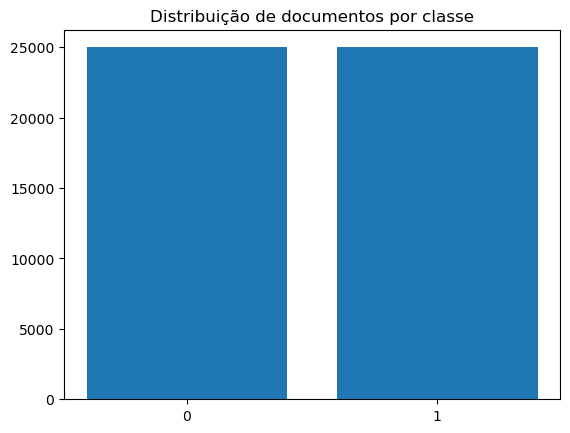

[25000 25000]


In [56]:
plt.figure()
plt.title("Distribuição de documentos por classe")
labels = [str(val) for val in np.arange(2)]
sizes, _ = np.histogram(yb, bins=2)
plt.bar(labels, sizes)
plt.show()

print(np.histogram(yb, bins=2)[0])

In [7]:
corpus_treino_b, corpus_teste_b, y_treino_b, y_teste_b = train_test_split(corpus, yb, test_size=1/3, shuffle=True, stratify=yb, random_state=42)

print("Dados Treino")
print("- Número de documentos para treino: ", len(corpus_treino_b))
print("- Número de avaliações para treino: ", len(y_treino_b))

print("\nDados Teste")
print("- Número de documentos para teste: ", len(corpus_teste_b))
print("- Número de avaliações para teste: ", len(y_teste_b))

Dados Treino
- Número de documentos para treino:  33333
- Número de avaliações para treino:  33333

Dados Teste
- Número de documentos para teste:  16667
- Número de avaliações para teste:  16667


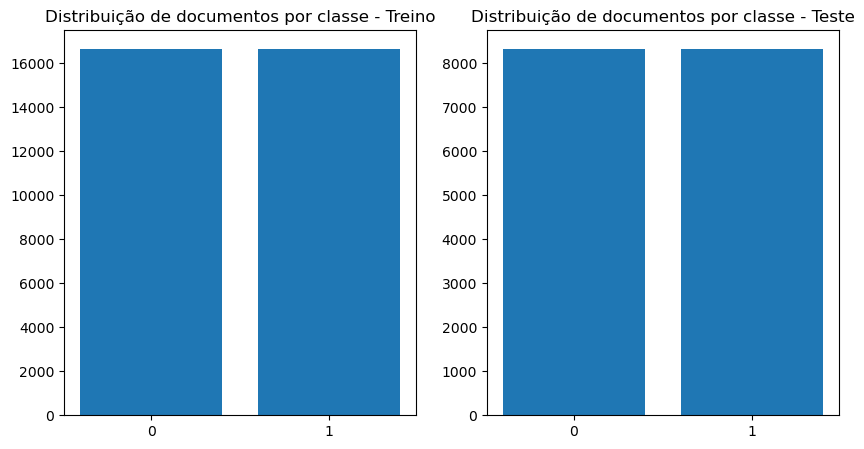

[8334 8333]


In [59]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title("Distribuição de documentos por classe - Treino")
labels = [str(val) for val in np.arange(2)]
sizes, _ = np.histogram(y_treino_b, bins=2)
plt.bar(labels, sizes)

plt.subplot(122)
plt.title("Distribuição de documentos por classe - Teste")
labels = [str(val) for val in np.arange(2)]
sizes, _ = np.histogram(y_teste_b, bins=2)
plt.bar(labels, sizes)

plt.show()


<u>LogisticRegression</u>

    * Treino

In [8]:
corpus_treino_p = text2vector(corpus_treino_b, treino=True)
y_treino_e_b, _, _ = binClassify(corpus_treino_p, y_treino_b, model='LogisticRegression', treino=True)

Score:  0.999


    * Teste

In [9]:
corpus_teste_p = text2vector(corpus_teste_b, treino=False)
y_teste_e_b, tpr_lr, fpr_lr = binClassify(corpus_teste_p, y_teste_b, model='LogisticRegression', treino=False)

Score:  0.906


    * Resultados

Treino:
Número de erros:  46
Precisão:  0.998619986199862
Report de Classificação:                precision    recall  f1-score   support

           0       1.00      1.00      1.00     16666
           1       1.00      1.00      1.00     16667

    accuracy                           1.00     33333
   macro avg       1.00      1.00      1.00     33333
weighted avg       1.00      1.00      1.00     33333



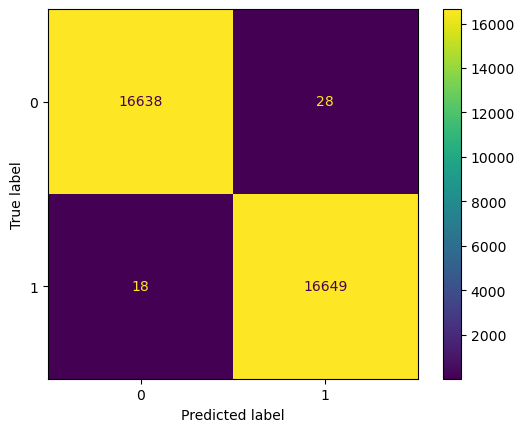

Teste:
Número de erros:  1572
Precisão:  0.9056818863622728
Report de Classificação:                precision    recall  f1-score   support

           0       0.91      0.90      0.90      8334
           1       0.90      0.92      0.91      8333

    accuracy                           0.91     16667
   macro avg       0.91      0.91      0.91     16667
weighted avg       0.91      0.91      0.91     16667



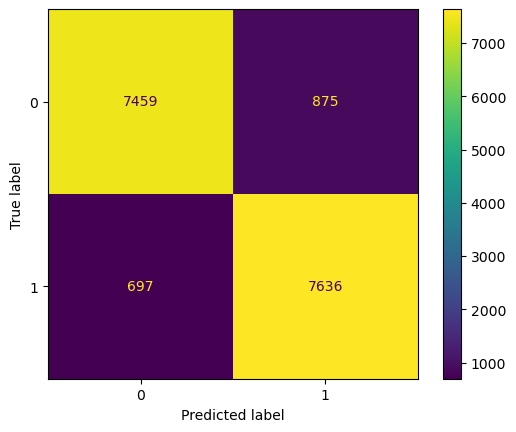

In [10]:
print("Treino:")
print("Número de erros: ", np.sum(y_treino_b != y_treino_e_b))
print("Precisão: ", accuracy_score(y_treino_b, y_treino_e_b))
print("Report de Classificação: ", classification_report(y_treino_b, y_treino_e_b))

matriz_confusao_treino_b = confusion_matrix(y_treino_b, y_treino_e_b)

disp = ConfusionMatrixDisplay(matriz_confusao_treino_b, display_labels=np.unique(y_treino_b))
disp.plot()
plt.show()


print("Teste:")
print("Número de erros: ", np.sum(y_teste_b != y_teste_e_b))
print("Precisão: ", accuracy_score(y_teste_b, y_teste_e_b))
print("Report de Classificação: ", classification_report(y_teste_b, y_teste_e_b))

matriz_confusao_teste_b = confusion_matrix(y_teste_b, y_teste_e_b)
tn_teste_lr, fp_teste_lr, fn_teste_lr, tp_teste_lr = matriz_confusao_teste_b.ravel()

tpr_teste_lr = tp_teste_lr/(tp_teste_lr + fp_teste_lr)
fpr_teste_lr = fp_teste_lr/(fp_teste_lr + tn_teste_lr)

disp = ConfusionMatrixDisplay(matriz_confusao_teste_b, display_labels=np.unique(y_teste_b))
disp.plot()
plt.show()


<u>LinearSVC</u>

    * Treino

In [11]:
y_treino_e_b, _, _ = binClassify(corpus_treino_p, y_treino_b, model='LinearSVC', treino=True)

Score:  0.987


    * Teste

In [12]:
y_teste_e_b, tpr_lSvm, fpr_lSvm = binClassify(corpus_teste_p, y_teste_b, model='LinearSVC', treino=False)

Score:  0.905


    * Resultados

Treino:
Número de erros:  432
Precisão:  0.987039870398704
Report de Classificação:                precision    recall  f1-score   support

           0       0.99      0.98      0.99     16666
           1       0.98      0.99      0.99     16667

    accuracy                           0.99     33333
   macro avg       0.99      0.99      0.99     33333
weighted avg       0.99      0.99      0.99     33333



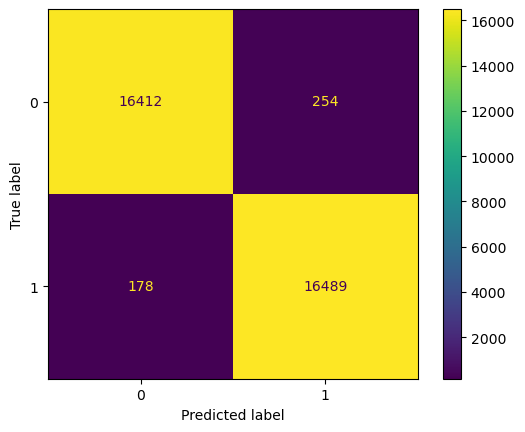

Teste:
Número de erros:  1585
Precisão:  0.9049019019619607
Report de Classificação:                precision    recall  f1-score   support

           0       0.91      0.90      0.90      8334
           1       0.90      0.91      0.91      8333

    accuracy                           0.90     16667
   macro avg       0.91      0.90      0.90     16667
weighted avg       0.91      0.90      0.90     16667



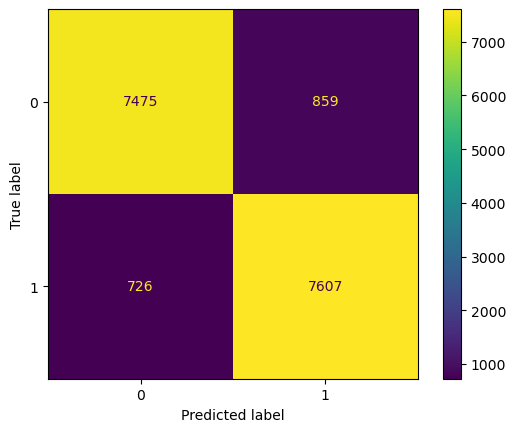

In [13]:
print("Treino:")
print("Número de erros: ", np.sum(y_treino_b != y_treino_e_b))
print("Precisão: ", accuracy_score(y_treino_b, y_treino_e_b))
print("Report de Classificação: ", classification_report(y_treino_b, y_treino_e_b))

matriz_confusao_treino_b = confusion_matrix(y_treino_b, y_treino_e_b)

disp = ConfusionMatrixDisplay(matriz_confusao_treino_b, display_labels=np.unique(y_treino_b))
disp.plot()
plt.show()


print("Teste:")
print("Número de erros: ", np.sum(y_teste_b != y_teste_e_b))
print("Precisão: ", accuracy_score(y_teste_b, y_teste_e_b))
print("Report de Classificação: ", classification_report(y_teste_b, y_teste_e_b))

matriz_confusao_teste_b = confusion_matrix(y_teste_b, y_teste_e_b)
tn_teste_lSvm, fp_teste_lSvm, fn_teste_lSvm, tp_teste_lSvm = matriz_confusao_teste_b.ravel()

tpr_teste_lSvm = tp_teste_lSvm/(tp_teste_lSvm + fp_teste_lSvm)
fpr_teste_lSvm = fp_teste_lSvm/(fp_teste_lSvm + tn_teste_lSvm)

disp = ConfusionMatrixDisplay(matriz_confusao_teste_b, display_labels=np.unique(y_teste_b))
disp.plot()
plt.show()

<u>SVC</u>

    * Treino

In [14]:
y_treino_e_b, _, _ = binClassify(corpus_treino_p, y_treino_b, model='SVC', treino=True)

C:\Users\anaso\anaconda3\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Score:  0.987


    * Teste

In [15]:
y_teste_e_b, tpr_Svm, fpr_Svm = binClassify(corpus_teste_p, y_teste_b, model='SVC', treino=False)

Score:  0.905


    * Resultados

Treino:
Número de erros:  431
Precisão:  0.987069870698707
Report de Classificação:                precision    recall  f1-score   support

           0       0.99      0.98      0.99     16666
           1       0.98      0.99      0.99     16667

    accuracy                           0.99     33333
   macro avg       0.99      0.99      0.99     33333
weighted avg       0.99      0.99      0.99     33333



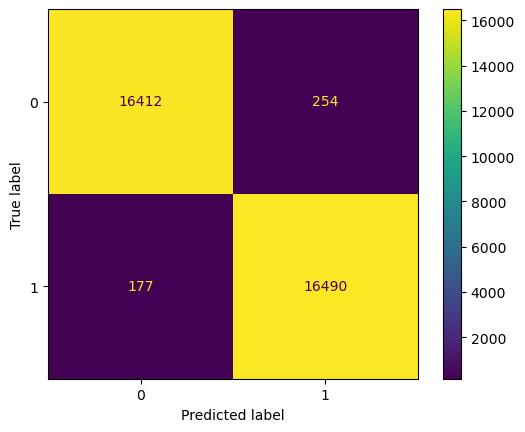

Teste:
Número de erros:  1589
Precisão:  0.9046619067618648
Report de Classificação:                precision    recall  f1-score   support

           0       0.91      0.90      0.90      8334
           1       0.90      0.91      0.91      8333

    accuracy                           0.90     16667
   macro avg       0.90      0.90      0.90     16667
weighted avg       0.90      0.90      0.90     16667



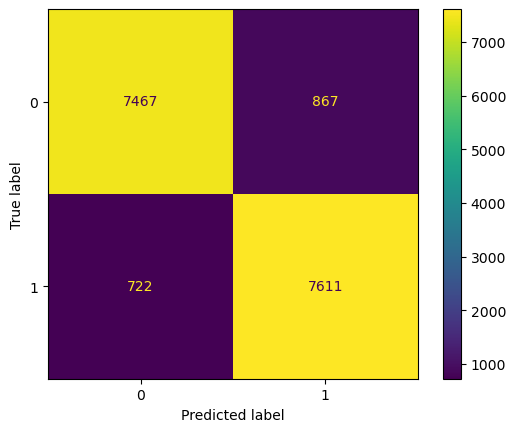

In [16]:
print("Treino:")
print("Número de erros: ", np.sum(y_treino_b != y_treino_e_b))
print("Precisão: ", accuracy_score(y_treino_b, y_treino_e_b))
print("Report de Classificação: ", classification_report(y_treino_b, y_treino_e_b))

matriz_confusao_treino_b = confusion_matrix(y_treino_b, y_treino_e_b)

disp = ConfusionMatrixDisplay(matriz_confusao_treino_b, display_labels=np.unique(y_treino_b))
disp.plot()
plt.show()


print("Teste:")
print("Número de erros: ", np.sum(y_teste_b != y_teste_e_b))
print("Precisão: ", accuracy_score(y_teste_b, y_teste_e_b))
print("Report de Classificação: ", classification_report(y_teste_b, y_teste_e_b))

matriz_confusao_teste_b = confusion_matrix(y_teste_b, y_teste_e_b)
tn_teste_Svm, fp_teste_Svm, fn_teste_Svm, tp_teste_Svm = matriz_confusao_teste_b.ravel()

tpr_teste_Svm = tp_teste_Svm/(tp_teste_Svm + fp_teste_Svm)
fpr_teste_Svm = fp_teste_Svm/(fp_teste_Svm + tn_teste_Svm)

disp = ConfusionMatrixDisplay(matriz_confusao_teste_b, display_labels=np.unique(y_teste_b))
disp.plot()
plt.show()

<u>NaiveBayes</u>

    * Treino

In [17]:
y_treino_e_b, _, _ = binClassify(corpus_treino_p, y_treino_b, model='NaiveBayes', treino=True)

Score:  0.951


    * Teste

In [18]:
y_teste_e_b, tpr_nb, fpr_nb = binClassify(corpus_teste_p, y_teste_b, model='NaiveBayes', treino=False)

Score:  0.885


    * Resultados

Treino:
Número de erros:  1649
Precisão:  0.950529505295053
Report de Classificação:                precision    recall  f1-score   support

           0       0.95      0.95      0.95     16666
           1       0.95      0.95      0.95     16667

    accuracy                           0.95     33333
   macro avg       0.95      0.95      0.95     33333
weighted avg       0.95      0.95      0.95     33333



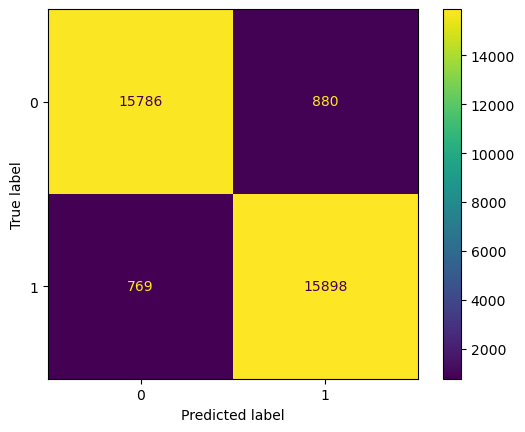

Teste:
Número de erros:  1915
Precisão:  0.8851022979540409
Report de Classificação:                precision    recall  f1-score   support

           0       0.89      0.88      0.88      8334
           1       0.88      0.89      0.89      8333

    accuracy                           0.89     16667
   macro avg       0.89      0.89      0.89     16667
weighted avg       0.89      0.89      0.89     16667



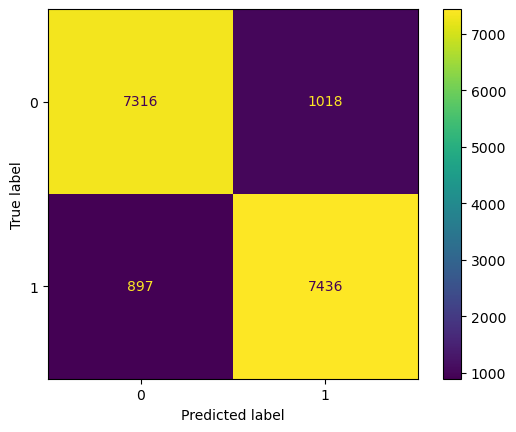

In [19]:
print("Treino:")
print("Número de erros: ", np.sum(y_treino_b != y_treino_e_b))
print("Precisão: ", accuracy_score(y_treino_b, y_treino_e_b))
print("Report de Classificação: ", classification_report(y_treino_b, y_treino_e_b))


matriz_confusao_treino_b = confusion_matrix(y_treino_b, y_treino_e_b)

disp = ConfusionMatrixDisplay(matriz_confusao_treino_b, display_labels=np.unique(y_treino_b))
disp.plot()
plt.show()


print("Teste:")
print("Número de erros: ", np.sum(y_teste_b != y_teste_e_b))
print("Precisão: ", accuracy_score(y_teste_b, y_teste_e_b))
print("Report de Classificação: ", classification_report(y_teste_b, y_teste_e_b))


matriz_confusao_teste_b = confusion_matrix(y_teste_b, y_teste_e_b)
tn_teste_nb, fp_teste_nb, fn_teste_nb, tp_teste_nb = matriz_confusao_teste_b.ravel()

tpr_teste_nb = tp_teste_nb/(tp_teste_nb + fp_teste_nb)
fpr_teste_nb = fp_teste_nb/(fp_teste_nb + tn_teste_nb)

disp = ConfusionMatrixDisplay(matriz_confusao_teste_b, display_labels=np.unique(y_teste_b))
disp.plot()
plt.show()


### Classificação Multiclasse

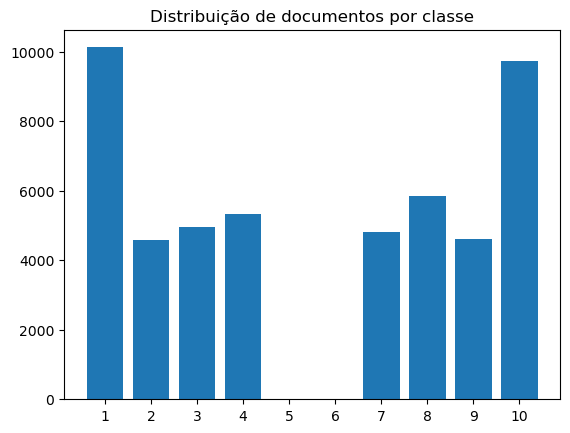

[10122  4586  4961  5331     0     0  4803  5859  4607  9731]


In [20]:
plt.figure()
plt.title("Distribuição de documentos por classe")
labels = [str(val) for val in np.arange(10)+1]
sizes, _ = np.histogram(y)
plt.bar(labels, sizes)
plt.show()

print(np.histogram(y)[0])

In [60]:
counts = np.histogram(y)[0]
min_class_samples = np.min(counts[counts!= 0]) 
# print(min_class_samples)
min_class_samples = int(min_class_samples/2)

corpus_treino_m = np.hstack(([corpus[index] for index in np.argwhere(y==1)[:min_class_samples].ravel()], 
                           [corpus[index] for index in np.argwhere(y==2)[:min_class_samples].ravel()], 
                           [corpus[index] for index in np.argwhere(y==3)[:min_class_samples].ravel()], 
                           [corpus[index] for index in np.argwhere(y==4)[:min_class_samples].ravel()], 
                            [corpus[index] for index in np.argwhere(y==7)[:min_class_samples].ravel()],
                           [corpus[index] for index in np.argwhere(y==8)[:min_class_samples].ravel()], 
                           [corpus[index] for index in np.argwhere(y==9)[:min_class_samples].ravel()], 
                           [corpus[index] for index in np.argwhere(y==10)[:min_class_samples].ravel()]))

corpus_teste_m = np.hstack(([corpus[index] for index in np.argwhere(y==1)[min_class_samples:].ravel()], 
                           [corpus[index] for index in np.argwhere(y==2)[min_class_samples:].ravel()], 
                           [corpus[index] for index in np.argwhere(y==3)[min_class_samples:].ravel()], 
                           [corpus[index] for index in np.argwhere(y==4)[min_class_samples:].ravel()], 
                            [corpus[index] for index in np.argwhere(y==7)[min_class_samples:].ravel()],
                           [corpus[index] for index in np.argwhere(y==8)[min_class_samples:].ravel()], 
                           [corpus[index] for index in np.argwhere(y==9)[min_class_samples:].ravel()], 
                           [corpus[index] for index in np.argwhere(y==10)[min_class_samples:].ravel()]))

y_treino_m = np.hstack((y[y==1][:min_class_samples], y[y==2][:min_class_samples], y[y==3][:min_class_samples], y[y==4][:min_class_samples],
                        y[y==7][:min_class_samples], y[y==8][:min_class_samples], y[y==9][:min_class_samples], y[y==10][:min_class_samples]))

y_teste_m = np.hstack((y[y==1][min_class_samples:], y[y==2][min_class_samples:], y[y==3][min_class_samples:], y[y==4][min_class_samples:],
                        y[y==7][min_class_samples:], y[y==8][min_class_samples:], y[y==9][min_class_samples:], y[y==10][min_class_samples:]))

# print(corpus_treino_m.shape)
# print(y_treino_m.shape)
# print(corpus_teste_m.shape)
# print(y_teste_m.shape)

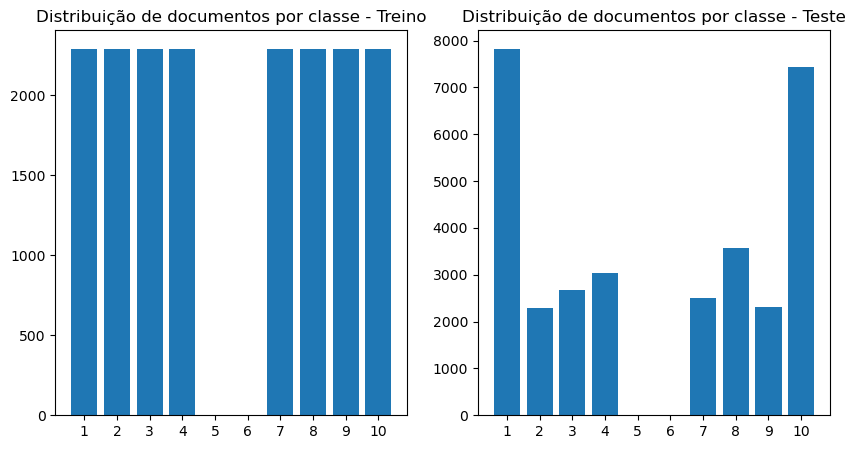

In [61]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title("Distribuição de documentos por classe - Treino")
labels = [str(val) for val in np.arange(10)+1]
sizes, _ = np.histogram(y_treino_m)
plt.bar(labels, sizes)

plt.subplot(122)
plt.title("Distribuição de documentos por classe - Teste")
labels = [str(val) for val in np.arange(10)+1]
sizes, _ = np.histogram(y_teste_m)
plt.bar(labels, sizes)

plt.show()

In [62]:
print("Dados Treino")
print("- Número de documentos para treino: ", len(corpus_treino_m))
print("- Número de avaliações para treino: ", len(y_treino_m))

print("\nDados Teste")
print("- Número de documentos para teste: ", len(corpus_teste_m))
print("- Número de avaliações para teste: ", len(y_teste_m))

Dados Treino
- Número de documentos para treino:  18344
- Número de avaliações para treino:  18344

Dados Teste
- Número de documentos para teste:  31656
- Número de avaliações para teste:  31656


In [63]:
corpus_treino_p = text2vector(corpus_treino_m, treino=True)
corpus_teste_p = text2vector(corpus_teste_m, treino=False)

<u>LogisticRegression</u>

    * Treino

In [64]:
y_treino_e_m = multiClassify(corpus_treino_p, y_treino_m, model='LogisticRegression', treino=True)

Score:  1.0


    * Teste

In [65]:
y_teste_e_m = multiClassify(corpus_teste_p, y_teste_m, model='LogisticRegression', treino=False)

Score:  0.376


    * Resultados

Treino:
Número de erros:  1
Precisão:  0.9999454862625382
Report de Classificação:                precision    recall  f1-score   support

           1       1.00      1.00      1.00      2293
           2       1.00      1.00      1.00      2293
           3       1.00      1.00      1.00      2293
           4       1.00      1.00      1.00      2293
           7       1.00      1.00      1.00      2293
           8       1.00      1.00      1.00      2293
           9       1.00      1.00      1.00      2293
          10       1.00      1.00      1.00      2293

    accuracy                           1.00     18344
   macro avg       1.00      1.00      1.00     18344
weighted avg       1.00      1.00      1.00     18344



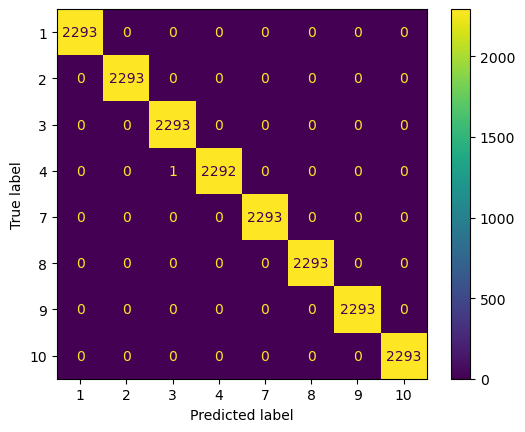

Teste:
Número de erros:  19768
Precisão:  0.37553702299722014
Report de Classificação:                precision    recall  f1-score   support

           1       0.71      0.54      0.61      7829
           2       0.15      0.24      0.19      2293
           3       0.19      0.24      0.22      2668
           4       0.26      0.31      0.28      3038
           7       0.23      0.28      0.25      2510
           8       0.25      0.22      0.24      3566
           9       0.17      0.27      0.21      2314
          10       0.63      0.46      0.53      7438

    accuracy                           0.38     31656
   macro avg       0.33      0.32      0.32     31656
weighted avg       0.44      0.38      0.40     31656



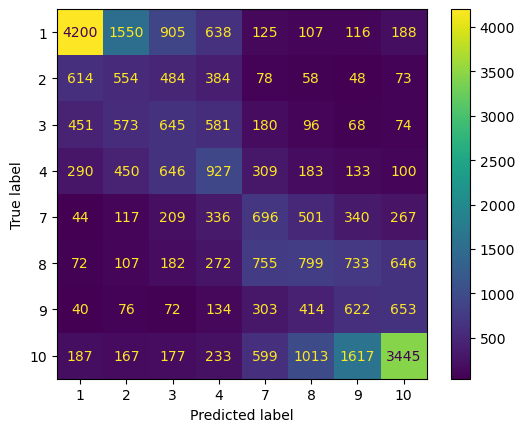

In [66]:
print("Treino:")
print("Número de erros: ", np.sum(y_treino_m != y_treino_e_m))
print("Precisão: ", accuracy_score(y_treino_m, y_treino_e_m))
print("Report de Classificação: ", classification_report(y_treino_m, y_treino_e_m))

matriz_confusao_treino_m = confusion_matrix(y_treino_m, y_treino_e_m)

disp = ConfusionMatrixDisplay(matriz_confusao_treino_m, display_labels=np.unique(y_treino_m))
disp.plot()
plt.show()


print("Teste:")
print("Número de erros: ", np.sum(y_teste_m != y_teste_e_m))
print("Precisão: ", accuracy_score(y_teste_m, y_teste_e_m))
print("Report de Classificação: ", classification_report(y_teste_m, y_teste_e_m))

matriz_confusao_teste_m = confusion_matrix(y_teste_m, y_teste_e_m)

disp = ConfusionMatrixDisplay(matriz_confusao_teste_m, display_labels=np.unique(y_treino_m))
disp.plot()
plt.show()

<u>LinearSVC</u>

    * Treino

In [67]:
y_treino_e_m = multiClassify(corpus_treino_p, y_treino_m, model='LinearSVC', treino=True)

Score:  0.988


    * Teste

In [68]:
y_teste_e_m = multiClassify(corpus_teste_p, y_teste_m, model='LinearSVC', treino=False)

Score:  0.413


    * Resultados

Treino:
Número de erros:  225
Precisão:  0.9877344090710859
Report de Classificação:                precision    recall  f1-score   support

           1       0.93      1.00      0.96      2293
           2       1.00      0.96      0.98      2293
           3       1.00      0.98      0.99      2293
           4       1.00      0.99      1.00      2293
           7       1.00      1.00      1.00      2293
           8       1.00      0.99      1.00      2293
           9       1.00      0.99      0.99      2293
          10       0.99      0.99      0.99      2293

    accuracy                           0.99     18344
   macro avg       0.99      0.99      0.99     18344
weighted avg       0.99      0.99      0.99     18344



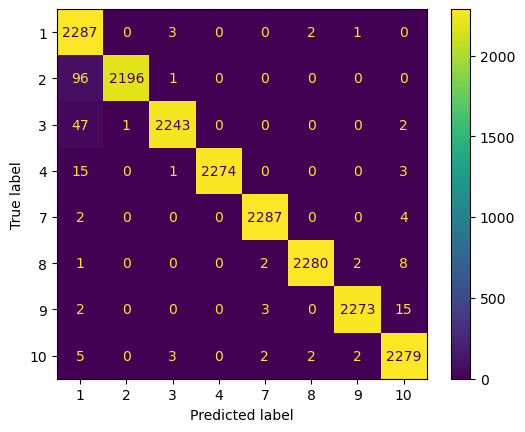

Teste:
Número de erros:  18578
Precisão:  0.41312863280262824
Report de Classificação:                precision    recall  f1-score   support

           1       0.67      0.68      0.68      7829
           2       0.16      0.18      0.17      2293
           3       0.19      0.19      0.19      2668
           4       0.27      0.27      0.27      3038
           7       0.23      0.26      0.24      2510
           8       0.26      0.19      0.22      3566
           9       0.16      0.20      0.18      2314
          10       0.61      0.56      0.58      7438

    accuracy                           0.41     31656
   macro avg       0.32      0.32      0.32     31656
weighted avg       0.42      0.41      0.42     31656



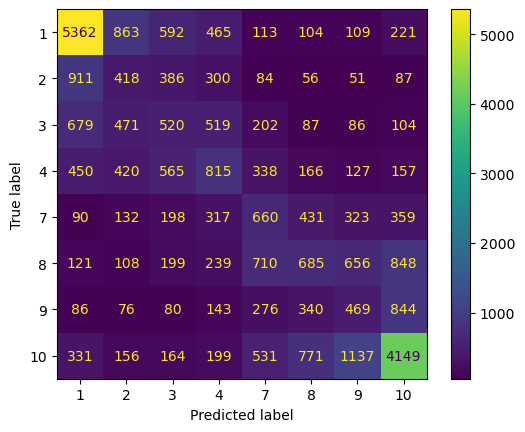

In [69]:
print("Treino:")
print("Número de erros: ", np.sum(y_treino_m != y_treino_e_m))
print("Precisão: ", accuracy_score(y_treino_m, y_treino_e_m))
print("Report de Classificação: ", classification_report(y_treino_m, y_treino_e_m))

matriz_confusao_treino_m = confusion_matrix(y_treino_m, y_treino_e_m)

disp = ConfusionMatrixDisplay(matriz_confusao_treino_m, display_labels=np.unique(y_treino_m))
disp.plot()
plt.show()


print("Teste:")
print("Número de erros: ", np.sum(y_teste_m != y_teste_e_m))
print("Precisão: ", accuracy_score(y_teste_m, y_teste_e_m))
print("Report de Classificação: ", classification_report(y_teste_m, y_teste_e_m))

matriz_confusao_teste_m = confusion_matrix(y_teste_m, y_teste_e_m)

disp = ConfusionMatrixDisplay(matriz_confusao_teste_m, display_labels=np.unique(y_treino_m))
disp.plot()
plt.show()

<u>SVC</u>

    * Treino

In [70]:
y_treino_e_m = multiClassify(corpus_treino_p, y_treino_m, model='SVC', treino=True)

C:\Users\anaso\anaconda3\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Score:  1.0


    * Teste

In [71]:
y_teste_e_m = multiClassify(corpus_teste_p, y_teste_m, model='SVC', treino=False)

Score:  0.374


    * Resultados

Treino:
Número de erros:  1
Precisão:  0.9999454862625382
Report de Classificação:                precision    recall  f1-score   support

           1       1.00      1.00      1.00      2293
           2       1.00      1.00      1.00      2293
           3       1.00      1.00      1.00      2293
           4       1.00      1.00      1.00      2293
           7       1.00      1.00      1.00      2293
           8       1.00      1.00      1.00      2293
           9       1.00      1.00      1.00      2293
          10       1.00      1.00      1.00      2293

    accuracy                           1.00     18344
   macro avg       1.00      1.00      1.00     18344
weighted avg       1.00      1.00      1.00     18344



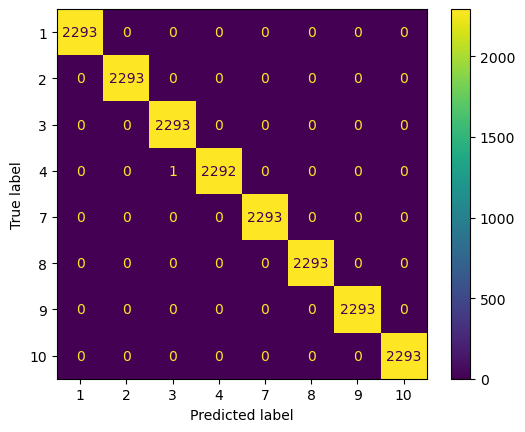

Teste:
Número de erros:  19811
Precisão:  0.37417867071013394
Report de Classificação:                precision    recall  f1-score   support

           1       0.72      0.52      0.60      7829
           2       0.16      0.27      0.20      2293
           3       0.20      0.25      0.22      2668
           4       0.28      0.32      0.30      3038
           7       0.24      0.31      0.27      2510
           8       0.26      0.23      0.24      3566
           9       0.17      0.27      0.21      2314
          10       0.65      0.44      0.53      7438

    accuracy                           0.37     31656
   macro avg       0.33      0.33      0.32     31656
weighted avg       0.45      0.37      0.40     31656



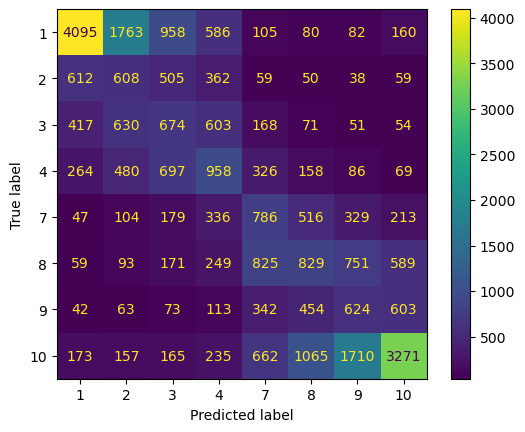

In [72]:
print("Treino:")
print("Número de erros: ", np.sum(y_treino_m != y_treino_e_m))
print("Precisão: ", accuracy_score(y_treino_m, y_treino_e_m))
print("Report de Classificação: ", classification_report(y_treino_m, y_treino_e_m))

matriz_confusao_treino_m = confusion_matrix(y_treino_m, y_treino_e_m)

disp = ConfusionMatrixDisplay(matriz_confusao_treino_m, display_labels=np.unique(y_treino_m))
disp.plot()
plt.show()


print("Teste:")
print("Número de erros: ", np.sum(y_teste_m != y_teste_e_m))
print("Precisão: ", accuracy_score(y_teste_m, y_teste_e_m))
print("Report de Classificação: ", classification_report(y_teste_m, y_teste_e_m))

matriz_confusao_teste_m = confusion_matrix(y_teste_m, y_teste_e_m)

disp = ConfusionMatrixDisplay(matriz_confusao_teste_m, display_labels=np.unique(y_treino_m))
disp.plot()
plt.show()

<u>NaiveBayes</u>

    * Treino

In [73]:
y_treino_e_m = multiClassify(corpus_treino_p, y_treino_m, model='NaiveBayes', treino=True)

Score:  0.992


    * Teste

In [74]:
y_teste_e_m = multiClassify(corpus_teste_p, y_teste_m, model='NaiveBayes', treino=False)

Score:  0.363


    * Resultados

Treino:
Número de erros:  153
Precisão:  0.9916593981683384
Report de Classificação:                precision    recall  f1-score   support

           1       0.99      0.99      0.99      2293
           2       1.00      0.99      1.00      2293
           3       1.00      0.99      0.99      2293
           4       1.00      0.99      1.00      2293
           7       0.98      0.99      0.99      2293
           8       0.99      0.99      0.99      2293
           9       0.99      0.99      0.99      2293
          10       0.99      0.98      0.99      2293

    accuracy                           0.99     18344
   macro avg       0.99      0.99      0.99     18344
weighted avg       0.99      0.99      0.99     18344



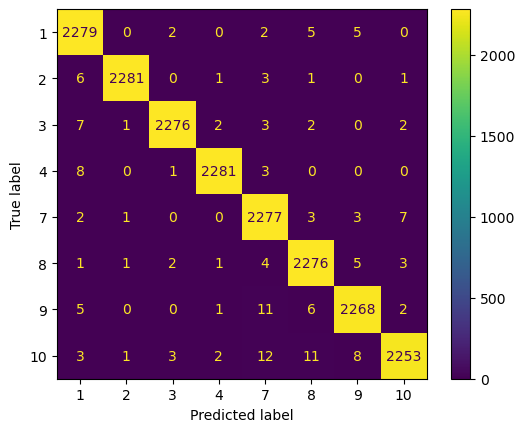

Teste:
Número de erros:  20173
Precisão:  0.36274323982815265
Report de Classificação:                precision    recall  f1-score   support

           1       0.71      0.53      0.61      7829
           2       0.16      0.25      0.19      2293
           3       0.19      0.27      0.22      2668
           4       0.25      0.30      0.27      3038
           7       0.23      0.29      0.25      2510
           8       0.25      0.23      0.24      3566
           9       0.16      0.27      0.20      2314
          10       0.67      0.40      0.50      7438

    accuracy                           0.36     31656
   macro avg       0.33      0.32      0.31     31656
weighted avg       0.44      0.36      0.39     31656



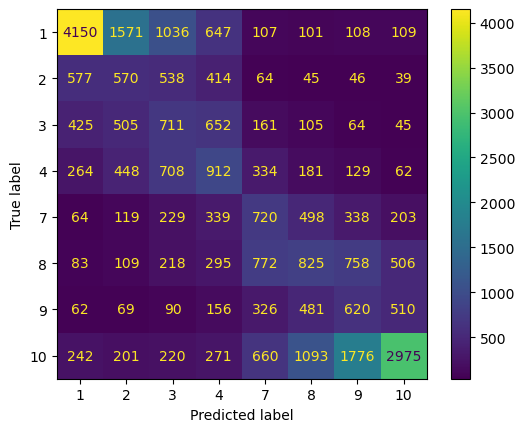

In [75]:
print("Treino:")
print("Número de erros: ", np.sum(y_treino_m != y_treino_e_m))
print("Precisão: ", accuracy_score(y_treino_m, y_treino_e_m))
print("Report de Classificação: ", classification_report(y_treino_m, y_treino_e_m))

matriz_confusao_treino_m = confusion_matrix(y_treino_m, y_treino_e_m)

disp = ConfusionMatrixDisplay(matriz_confusao_treino_m, display_labels=np.unique(y_treino_m))
disp.plot()
plt.show()


print("Teste:")
print("Número de erros: ", np.sum(y_teste_m != y_teste_e_m))
print("Precisão: ", accuracy_score(y_teste_m, y_teste_e_m))
print("Report de Classificação: ", classification_report(y_teste_m, y_teste_e_m))

matriz_confusao_teste_m = confusion_matrix(y_teste_m, y_teste_e_m)

disp = ConfusionMatrixDisplay(matriz_confusao_teste_m, display_labels=np.unique(y_treino_m))
disp.plot()
plt.show()

## Comparação

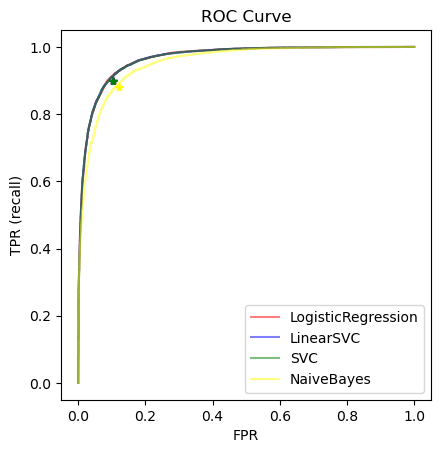

In [76]:
plt.figure()
plt.title("ROC Curve")
plt.plot(tpr_lr, fpr_lr, label='LogisticRegression', color='red', alpha=0.5)
plt.plot(fpr_teste_lr, tpr_teste_lr, "*", color='red')
plt.plot(tpr_lSvm, fpr_lSvm, label='LinearSVC', color='blue', alpha=0.5)
plt.plot(fpr_teste_lSvm, tpr_teste_lSvm, "*", color='blue')
plt.plot(tpr_Svm, fpr_Svm, label='SVC', color='green', alpha=0.5)
plt.plot(fpr_teste_Svm, tpr_teste_Svm, "*", color='green')
plt.plot(tpr_nb, fpr_nb, label='NaiveBayes', color='yellow', alpha=0.5)
plt.plot(fpr_teste_nb, tpr_teste_nb, "*", color='yellow')
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.axis('scaled')
plt.legend()
plt.show()